# Note on Masked Convolutions

A major motivation for using two stacks (a horizontal and vertical stack) suggested by van den Oord et al. is
to avoid a blind spot (see figure 1 in van den Oord et al. 2016).  However, the figure is misleading.  It suggests two convolutions
of the form:

```
1 1 1 1 1
1 1 1 1 1
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
```
(for the first layer's vertical conv)

and
```
1 1 0 0 0
```
(for the first layer's horizontal conv)

For subsequent conv's, the center pixel can be included without including information about that pixel in the input,
suggesting the use of
```
1 1 1 1 1
1 1 1 1 1
0 0 1 0 0
0 0 0 0 0
0 0 0 0 0
```
(for the subsequent layers' vertical conv)

and
```
1 1 1 0 0
```
(for the subsequent layers' horizontal conv)

Turukin, in his blog post, even uses:
```
1 1 1 1 1
1 1 1 1 1
1 1 1 0 0
0 0 0 0 0
0 0 0 0 0
```
for subsequent vertical convolutions, as that does not break the autoregressive dependence structure.

I take it a step farther and use
```
1 1 1 1 1
1 1 1 1 1
1 1 1 1 1
0 0 0 0 0
0 0 0 0 0
```
for my subsequent vertical convolutions (which I believe the authors of van den Oord intended); I show in
this notebook that it is the only formulation of secondary vertical
convolution masks that prevents blindspots while maintaining the autoregressive dependency structure.

In [1]:
from models.mnist_pixelcnn import *
import matplotlib.pyplot as plt
def show_tensor(tensor):
    plt.imshow(tensor.cpu().numpy())
    plt.colorbar()
    plt.show()

In [6]:
def run_experiment(mask_mode, horizontal_n_by_n=False):
    model = MNIST_PixelCNNNew(levels=2, layers=5, mask_mode=mask_mode, horizontal_2d_convs=horizontal_n_by_n)
    for param in model.parameters():
        if len(param.size()) == 4:
            param.data.fill_(1)
        else:
            param.data.fill_(0)
    test = torch.zeros(1, 1, 28, 28)
    test[0, 0, 14, 14] = 1
    test = Variable(test, requires_grad=False)
    plt.title("PixelCNN Input")
    show_tensor(test.data[0,0])
    logits = model(test)
    plt.title("PixelCNN Output Channel 1")
    show_tensor(logits.data[0,0,0])
    plt.title("PixelCNN Output Channel 2")
    show_tensor(logits.data[0,1,0])

## Experiments

For the experiments, I set all biases to zero and set the kernel matrices all to 1.  I use an image of all zeros with a single non-zero pixel (value 1) in the center.  I then run it through the gated convolutional network.  All non-zero pixels in the output show where information from the center pixel has propogated.

### Experiment 1: Masks Implied by Figure 1 of van den Oord et al.

I believe that in theory, in order to propose the use of a vertical and horizontal stack, van den Oord must have used the convolutions I used below (labeled "noblind"), but figure 1 of the paper seems to suggest kernel masks of the following form:

A VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
A HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  0.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV

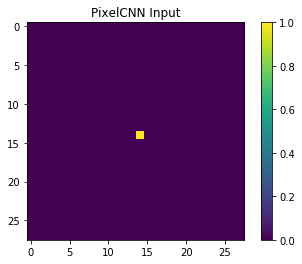

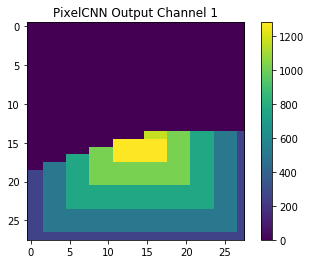

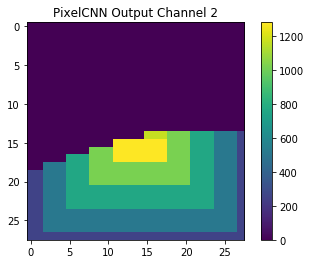

In [3]:
run_experiment("fig1-van-den-oord")

As you can see, this masking suffers from the blind spot noted by van den Oord.

### Experiment 2: Masks used by Sergei Turukin's blog post

In Sergei Turukin's [blog post](http://sergeiturukin.com/2017/02/24/gated-pixelcnn.html), he recommended masks of the following form:

A VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
A HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  0.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV

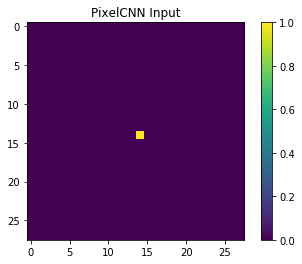

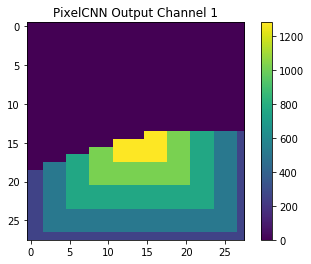

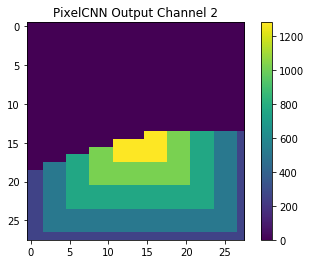

In [4]:
run_experiment("turukin")

These also suffer from a blindspot.

## Experiment 3: No blindspot

A VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
A HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  0.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 1 x 7. Mask:
[[ 1.  1.  1.  1.  0.  0.  0.]]
B VERTICAL MASKED CONV

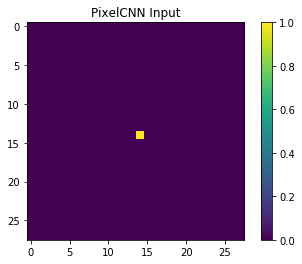

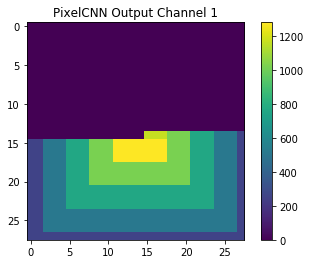

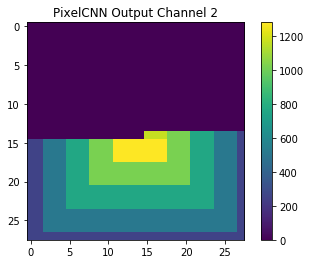

In [5]:
run_experiment("noblind")

As you can see there is no blind spot for these masks.

## BONUS: Experiment 4: NxN convolution in HORIZONTAL stack

In addition, you can make convolutions in the horizontal stack $N \times N$ instead of $1 \times N$ so long as you use a kernel mask like that suggested by Turukin in his blog post:

A VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
A HORIZONTAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B VERTICAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
B HORIZONTAL MASKED CONV: 7 x 7. Mask:
[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

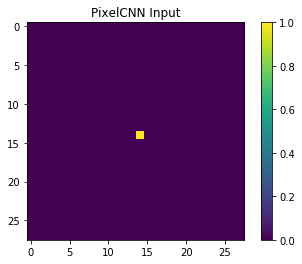

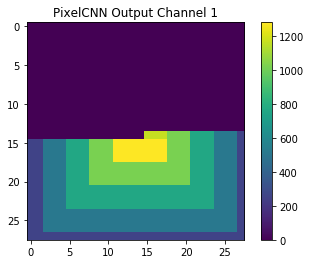

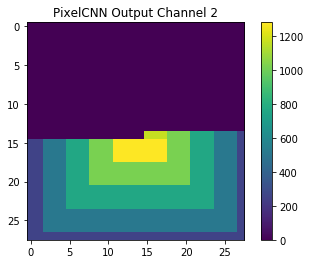

In [7]:
run_experiment("noblind", horizontal_n_by_n=True)

Though this results in the same receptive field, I intuitively think this will make it easier for left-to-right diagonal information to be passed through the network.